In [1]:
library("gdalcubes")
library("rstac")
library("stars")
library("stringr")
gdalcubes_options(parallel = TRUE)

Loading required package: abind

Loading required package: sf

Linking to GEOS 3.12.2, GDAL 3.9.2, PROJ 9.5.0; sf_use_s2() is TRUE



In [2]:
geo_box <- c(
  xmin = -125, ymin = 24, xmax = -66, ymax = 50
)
prj_box <- c(
  xmin = -2916310, ymin = 153627, xmax = 2945751, ymax = 3255273
)

items <- stac("https://planetarycomputer.microsoft.com/api/stac/v1") |>
  stac_search(
    collections = "gnatsgo-rasters",
    bbox = geo_box,
    limit = 1000
  ) |>
  post_request() |>
  items_sign(sign_planetary_computer())

#===========

cube1 <- cube_view(
  srs ="EPSG:5070",
  extent = list(
    t0 = "2020-01-01", t1 = "2020-12-31", # date is meaningless here
    left = prj_box[1], bottom = prj_box[2], right = prj_box[3], top = prj_box[4]
  ),
  dx = 1000, dy = 1000, dt = "P1Y",
  resampling = "average", aggregation = "first"
)

col1 <- stac_image_collection(
  items$features,
  asset_names = c(
    "soc0_30", # soil organic carbon in top 30cm (grams C per square meter)
    "aws0_30", # Available water storage in top 30 cm (mm).
    "pwsl1pomu", # Potential Wetland Soil Landscapes (PWSL) %map that meets PWSL
    "rootznemc" # depth (cm) that crop roots can extract water and nutrients
  )
)

data1 <-  raster_cube(col1, cube1, chunking = c(1, 750, 750))

In [3]:
cube2 <- cube_view(
  srs = "EPSG:5070",
  extent = list(
    t0 = "2020-01-01", t1 = "2020-12-31", # date is meaningless here
    left = prj_box[1], bottom = prj_box[2], right = prj_box[3], top = prj_box[4]
  ),
  dx = 1000, dy = 1000, dt = "P1Y",
  resampling = "mode", aggregation = "first"
)
col2 <- stac_image_collection(
  items$features,
  asset_names = c(
    "droughty" # top 1.52 cm -“1” for drought vulnerable “0” for non-droughty
  )
)

data2 <-  raster_cube(col2, cube2, chunking = c(1, 750, 750)) # t x y

In [ ]:
gssurgo_join <- join_bands(list(data1, data2))
gssurgo_join <- do.call(
  function(...) rename_bands(gssurgo_join, ...),
  as.list(setNames(str_remove_all(names(gssurgo_join), "X.\\."), names(gssurgo_join)))
)

In [7]:
col3_files <- c(
  list.files(
    path = "./", pattern = "(^PRISM).*(bil$)",
    recursive = TRUE, full.names = TRUE
  ),
  list.files(
    "./", pattern = "(^chirps).*(tif$)",
    recursive = TRUE, full.names = TRUE
  )
)

col3_names <- c(
  str_split_i(basename(col3_files[1:6]), "_", 2),
  str_split_i(basename(col3_files[7:7]), "_", 1)
)
col3_dates <- rep(as.Date("2020-01-01", "%Y-%m-%d"), 7)

col3 <- create_image_collection(
  col3_files,
  date_time = col3_dates,
  band_names = col3_names
)

cube3 <- cube_view(
  srs = "EPSG:5070",
  extent = list(
    t0 = "2020-01-01", t1 = "2020-12-31", # date is meaningless here
    left = prj_box[1], bottom = prj_box[2], right = prj_box[3], top = prj_box[4]
  ),
  dx = 1000, dy = 1000, dt = "P1Y",
  resampling = "average", aggregation = "first"
)

data3 <- raster_cube(col3, cube3, chunking = c(1, 750, 750))

#============

data_join <- join_bands(list(data3, gssurgo_join))

data_join <- do.call(
  function(...) rename_bands(data_join, ...),
  as.list(setNames(str_remove_all(names(data_join), "X.\\."), names(data_join)))
)

In [9]:
write_ncdf(
  data_join,
  fname = "gis_data_1km.nc"
)

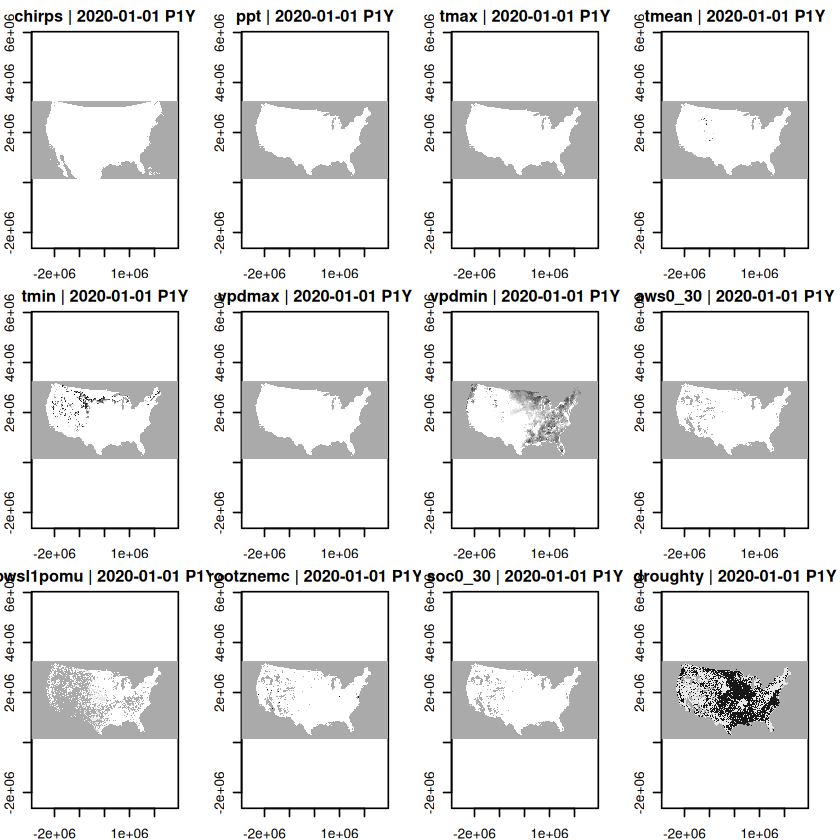

In [10]:
plot(data_join)